In [25]:
# Define the scenario
scen = "hist"  # Options: "hist" for historical or "ssp" for SSP scenarios

# Define target coordinates and domain bounds based on the ship
ship = "gj"  # Options: "gj" or "gb"

if ship == "gj":
    # Coordinates and bounds for ship "gj"
    # Target coordinates (if needed)
    # target_lon = 119.5394
    # target_lat = 23.35106

    # Define the domain bounds
    lon_min, lon_max = 119.5316, 119.5512
    lat_min, lat_max = 23.3465, 23.3555

elif ship == "gb":
    # Coordinates and bounds for ship "gb"
    # target_lon = 119.5565
    # target_lat = 23.3495

    # Define the domain bounds
    lon_min, lon_max = 119.5512437, 119.5609498
    lat_min, lat_max = 23.3404259, 23.3585524
    # Define the domain bounds
    #lon_min, lon_max = 119.551244, 119.560949
    #lat_min, lat_max = 23.340425, 23.358552

else:
    raise ValueError(f"Unknown ship type: {ship}")

# Print the configured parameters for validation
print(f"Scenario: {scen}")
print(f"Ship: {ship}")
print(f"Domain bounds:")
print(f"  Longitude range: {lon_min} to {lon_max}")
print(f"  Latitude range: {lat_min} to {lat_max}")
   

Scenario: hist
Ship: gj
Domain bounds:
  Longitude range: 119.5316 to 119.5512
  Latitude range: 23.3465 to 23.3555


In [26]:
import xarray as xr

# File paths
base_path = f"/lfs/home/ioloi/lfs_dir/project_UCH/data/d03{ship}_{scen}/"
salt_file = f"{base_path}ITRI_penghu.d03{ship}_salt_L0.nc"
temp_file = f"{base_path}ITRI_penghu.d03{ship}_temp_L0.nc"
u_file = f"{base_path}ITRI_penghu.d03{ship}_u_eastward_L0.nc"
v_file = f"{base_path}ITRI_penghu.d03{ship}_v_northward_L0.nc"

# Load datasets
salt_data = xr.open_dataset(salt_file)
temp_data = xr.open_dataset(temp_file)
u_data = xr.open_dataset(u_file)
v_data = xr.open_dataset(v_file)

# Check if lon_rho and lat_rho are variables
print("Salt data structure:\n", salt_data)

# Assign lon_rho and lat_rho as coordinates if not already
if 'lon_rho' not in salt_data.coords:
    salt_data = salt_data.set_coords(['lon_rho', 'lat_rho'])

# Select level 0 (s_rho=0)
salt_level_0 = salt_data['salt'].isel(s_rho=0)
temp_level_0 = temp_data['temp'].isel(s_rho=0)
u_level_0 = u_data['u_eastward'].isel(s_rho=0)
v_level_0 = v_data['v_northward'].isel(s_rho=0)


# Use .where() to filter data based on the domain
salt_in_domain = salt_level_0.where(
    (salt_data['lon_rho'] >= lon_min) & (salt_data['lon_rho'] <= lon_max) &
    (salt_data['lat_rho'] >= lat_min) & (salt_data['lat_rho'] <= lat_max),
    drop=True
)
temp_in_domain = temp_level_0.where(
    (temp_data['lon_rho'] >= lon_min) & (temp_data['lon_rho'] <= lon_max) &
    (temp_data['lat_rho'] >= lat_min) & (temp_data['lat_rho'] <= lat_max),
    drop=True
)
u_in_domain = u_level_0.where(
    (u_data['lon_rho'] >= lon_min) & (u_data['lon_rho'] <= lon_max) &
    (u_data['lat_rho'] >= lat_min) & (u_data['lat_rho'] <= lat_max),
    drop=True
)
v_in_domain = v_level_0.where(
    (v_data['lon_rho'] >= lon_min) & (v_data['lon_rho'] <= lon_max) &
    (v_data['lat_rho'] >= lat_min) & (v_data['lat_rho'] <= lat_max),
    drop=True
)




# Average over the domain
salt_avg = salt_in_domain.mean(dim=['eta_rho', 'xi_rho'])
temp_avg = temp_in_domain.mean(dim=['eta_rho', 'xi_rho'])
u_avg = u_in_domain.mean(dim=['eta_rho', 'xi_rho'])
v_avg = v_in_domain.mean(dim=['eta_rho', 'xi_rho'])

# Output the results
print("Average Salt over the domain:", salt_avg.values)
print("Average Temperature over the domain:", temp_avg.values)


Salt data structure:
 <xarray.Dataset>
Dimensions:     (ocean_time: 19081, eta_rho: 167, xi_rho: 334, s_rho: 1)
Coordinates:
  * ocean_time  (ocean_time) datetime64[ns] 2012-12-02T03:15:00 ... 2014-01-0...
    lon_rho     (eta_rho, xi_rho) float64 ...
    lat_rho     (eta_rho, xi_rho) float64 ...
  * s_rho       (s_rho) float64 -0.875
Dimensions without coordinates: eta_rho, xi_rho
Data variables:
    salt        (ocean_time, s_rho, eta_rho, xi_rho) float32 ...
Attributes: (12/38)
    CDI:               Climate Data Interface version 2.1.1 (https://mpimet.m...
    Conventions:       CF-1.4, SGRID-0.3
    file:              Result/tccip_ocean_avg_d03jg.nc
    format:            netCDF-3 64bit offset file
    type:              ROMS/TOMS nonlinear model averages file
    title:             Penghu
    ...                ...
    compiler_flags:    -fp-model precise -ip -O3
    tiling:            016x014
    history:           Fri Dec 06 16:45:19 2024: cdo sellevidx,1 ITRI_penghu....
    an

In [27]:
!pip install PyCO2SYS
import PyCO2SYS as pyco2

Defaulting to user installation because normal site-packages is not writeable


In [28]:
salinity = salt_avg.values
temperature = temp_avg.values

kwargs = dict(
    par1_type=1,
    par1=2400,
    par2_type=3,
    par2=8.191304348,
    salinity=33.83478261,
    temperature=25.76956522,
    temperature_out=temperature,
    pressure=1,
    pressure_out=15,
    total_silicate=50,
    total_phosphate=2,
    opt_pH_scale=1,
    opt_k_carbonic=4,
    opt_k_bisulfate=1,
    opt_total_borate=1,
)

results = pyco2.sys(**kwargs)
pH_value = results["pH_sws_out"]
print(f"pH Value: {pH_value}")


pH Value: [8.21906866 8.21902923 8.21903598 ... 8.23682521 8.23682488 8.23682468]


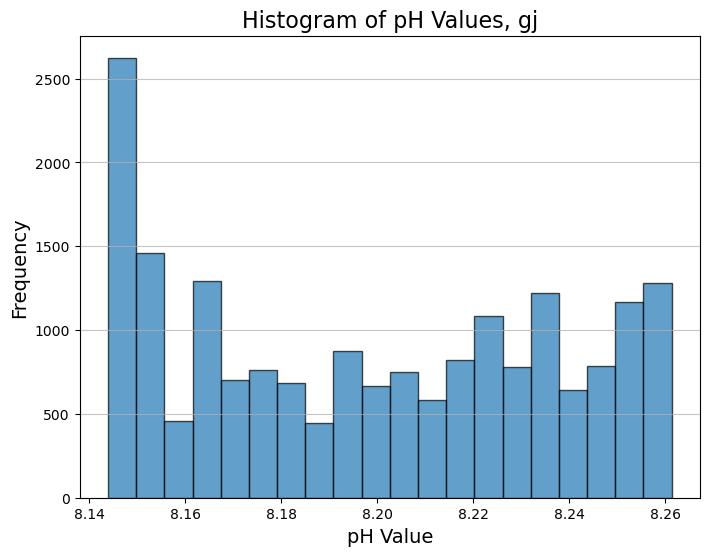

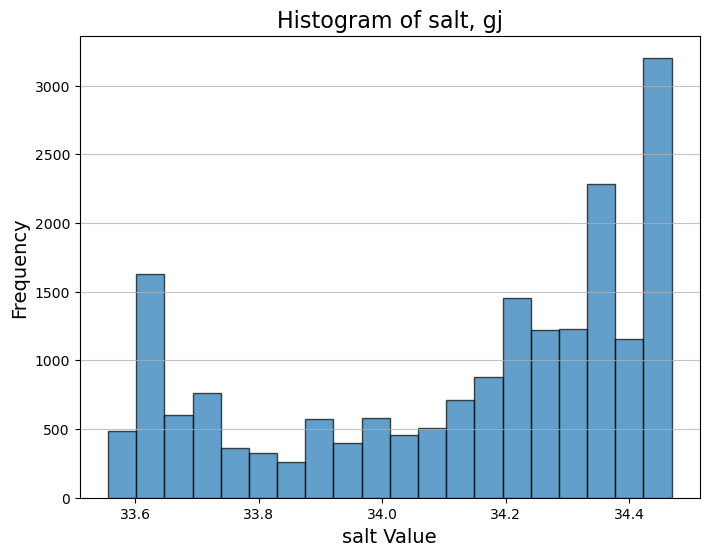

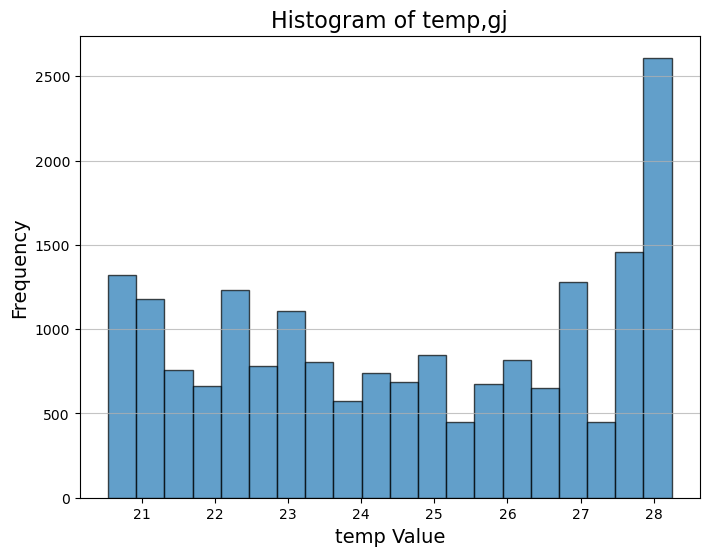

In [29]:
# Importing necessary libraries
import matplotlib.pyplot as plt
import numpy as np


# Plot the histogram of pH values
plt.figure(figsize=(8, 6))
plt.hist(pH_value, bins=20, edgecolor='black', alpha=0.7)
plt.title("Histogram of pH Values, "+ship, fontsize=16)
plt.xlabel("pH Value", fontsize=14)
plt.ylabel("Frequency", fontsize=14)
plt.grid(axis='y', alpha=0.75)
plt.show()

# Plot the histogram of pH values
plt.figure(figsize=(8, 6))
plt.hist(salt_avg, bins=20, edgecolor='black', alpha=0.7)
plt.title("Histogram of salt, "+ship, fontsize=16)
plt.xlabel("salt Value", fontsize=14)
plt.ylabel("Frequency", fontsize=14)
plt.grid(axis='y', alpha=0.75)
plt.show()

# Plot the histogram of pH values
plt.figure(figsize=(8, 6))
plt.hist(temp_avg, bins=20, edgecolor='black', alpha=0.7)
plt.title("Histogram of temp,"+ship, fontsize=16)
plt.xlabel("temp Value", fontsize=14)
plt.ylabel("Frequency", fontsize=14)
plt.grid(axis='y', alpha=0.75)
plt.show()

In [30]:
import xarray as xr

# Assuming `salt_data`, `salt_point`, `temp_point`, and `pH_value` are preloaded
# Extract the time coordinate from the salt_data
time = salt_data['ocean_time'].data  # Ensure it's a 1D array

# Extract raw data from DataArrays if necessary
salt_avg_data = salt_avg.data
temp_avg_data = temp_avg.data
u_avg_data = u_avg.data
v_avg_data = v_avg.data
pH_value_data = pH_value.data

speed = np.sqrt(u_avg_data**2 + v_avg_data**2)

# Create the Dataset
ds = xr.Dataset(
    {
        "salt": (["time"], salt_avg_data),
        "temp": (["time"], temp_avg_data),
        "speed": (["time"], speed),
        "pH": (["time"], pH_value),
    },
    coords={"time": time},  # Use 1D time as the coordinate
)

# Add metadata (optional)
ds["salt"].attrs["units"] = "PSU"
ds["salt"].attrs["long_name"] = "Salinity"
ds["temp"].attrs["units"] = "Celsius"
ds["temp"].attrs["long_name"] = "Temperature"
ds["speed"].attrs["units"] = "ms-1"
ds["speed"].attrs["long_name"] = "current speed"
ds["pH"].attrs["units"] = "pH"
ds["pH"].attrs["long_name"] = "pH Value"

# Save to a NetCDF file
output_file = base_path+"/ITRI_penghu.d03_"+scen+"_"+ship+".domain.nc"
ds.to_netcdf(output_file)

print(f"NetCDF file '{output_file}' saved successfully.")

NetCDF file '/lfs/home/ioloi/lfs_dir/project_UCH/data/d03gj_hist//ITRI_penghu.d03_hist_gj.domain.nc' saved successfully.
